# Chapter 2 End-to-end Machine Learning Project
## Trying a support vector machine reggressor on the housing dataset

In [1]:
from pathlib import Path
import tarfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as sk


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
    TransformedTargetRegressor,
)
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.utils.estimator_checks import check_estimator

from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

sk.set_config(
    display="diagram",
    transform_output="pandas",
)

### 1. Downloading the Data

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### 2. Creating a test set

Stratified on `median_income` categories since this is probably an important feature.

In [3]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
)

X, y = (
    housing.drop("median_house_value", axis="columns"),
    housing[["median_house_value"]].copy(),
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=X["income_cat"],
    random_state=42,
)

for df in [X_train, X_test, X]:
    df.drop("income_cat", axis=1, inplace=True)

### 3. Data Preprocessing

In [4]:
X_train_copy = X_train.copy()

#### 3.1 Pipeline for missing data & one-hot encoding

In [5]:
X_train_copy.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [6]:
impute_onehot_pipeline = ColumnTransformer(
    [
        (
            "impute_numerical",
            SimpleImputer(strategy="median"),
            make_column_selector(dtype_include="number"),
        ),
        (
            "impute_onehot_categorical",
            make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            ),
            make_column_selector(dtype_include=object),
        ),
    ],
    verbose_feature_names_out=False,
)

impute_onehot_pipeline

ColumnTransformer(transformers=[('impute_numerical',
                                 SimpleImputer(strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x143806860>),
                                ('impute_onehot_categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x143807940>)],
                  verbose_feature_names_out=False)

In [7]:
X_train_copy = impute_onehot_pipeline.fit_transform(X_train_copy)
X_train_copy.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

#### 3.2 Making a ratio transformer

In [8]:
class RatioTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, numerator_idx, denominator_idx, ratio_name):
        self.numerator_idx = numerator_idx
        self.denominator_idx = denominator_idx
        self.ratio_name = ratio_name

    def fit(self, X, y=None):
        if hasattr(X, "columns"):
            self.features_names_in_ = X.columns.values
        else:
            self.features_names_in_ = [f"x{i}" for i in range(self.n_features_in_)]
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.hstack(
            (
                X,
                (X[:, self.numerator_idx] / X[:, self.denominator_idx]).reshape(-1, 1),
            )
        )

    def get_feature_names_out(self, input_features=None):

        if input_features is None:
            input_features = self.features_names_in_
        else:
            assert len(input_features) == self.n_features_in_

        return np.append(input_features, self.ratio_name)


ratio_pipeline = make_pipeline(
    RatioTransformer(4, 6, "bedrooms_per_house"),
    RatioTransformer(3, 6, "rooms_per_house"),
    RatioTransformer(5, 6, "people_per_house"),
)

ratio_pipeline

Pipeline(steps=[('ratiotransformer-1',
                 RatioTransformer(denominator_idx=6, numerator_idx=4,
                                  ratio_name='bedrooms_per_house')),
                ('ratiotransformer-2',
                 RatioTransformer(denominator_idx=6, numerator_idx=3,
                                  ratio_name='rooms_per_house')),
                ('ratiotransformer-3',
                 RatioTransformer(denominator_idx=6, numerator_idx=5,
                                  ratio_name='people_per_house'))])

In [9]:
X_train_copy = ratio_pipeline.fit_transform(X_train_copy)
X_train_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,bedrooms_per_house,rooms_per_house,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,0.0,0.0,0.0,1.0,0.0,1.078337,3.211799,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,1.0,0.0,0.0,0.0,0.0,0.991597,5.504202,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,0.0,1.0,0.0,0.0,0.0,1.068966,5.334975,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,0.0,1.0,0.0,0.0,0.0,1.091026,5.351282,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,0.0,0.0,0.0,0.0,1.0,1.033276,3.725256,1.631399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,1.0,0.0,0.0,0.0,0.0,1.141491,4.277247,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,0.0,1.0,0.0,0.0,0.0,1.112782,5.535714,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,0.0,0.0,0.0,0.0,1.0,1.019737,5.157895,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,1.0,0.0,0.0,0.0,0.0,1.041766,4.511933,2.058473


In [10]:
corr_matrix = pd.concat([X_train_copy, y_train], axis=1).corr()
target_corr = corr_matrix["median_house_value"]
print(
    f"total_bedrooms correlation: {target_corr['total_bedrooms']} \nratio correlation: {target_corr['bedrooms_per_house']}",
    f"total_bedrooms correlation: {target_corr['total_rooms']} \nratio correlation: {target_corr['rooms_per_house']}",
    f"total_bedrooms correlation: {target_corr['population']} \nratio correlation: {target_corr['people_per_house']}",
    sep="\n\n",
)

total_bedrooms correlation: 0.0545304113500114 
ratio correlation: -0.04439130071115439

total_bedrooms correlation: 0.13745470571559049 
ratio correlation: 0.14366306207169802

total_bedrooms correlation: -0.020152880893942276 
ratio correlation: -0.03822435161498164


#### 3.3 Feature scaling

Ignoring the longitude & latitude columns for now. Also ignoring the one-hot encoded categorical features.

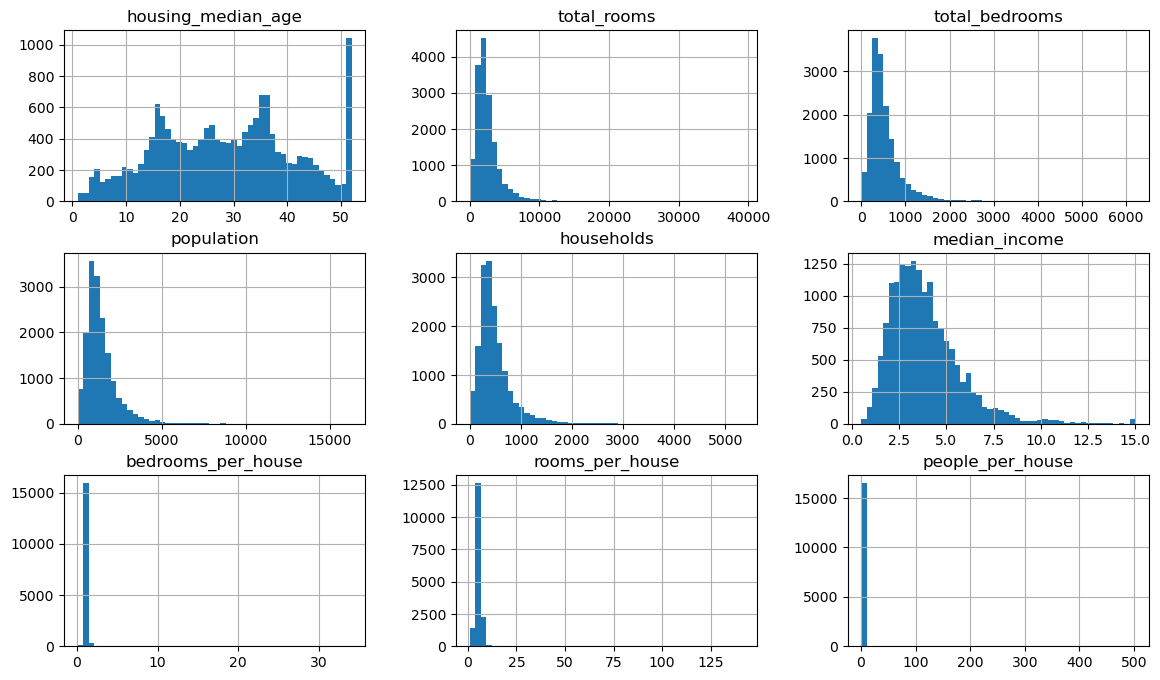

In [11]:
X_train_copy.drop(
    [
        "longitude",
        "latitude",
        "ocean_proximity_<1H OCEAN",
        "ocean_proximity_INLAND",
        "ocean_proximity_ISLAND",
        "ocean_proximity_NEAR BAY",
        "ocean_proximity_NEAR OCEAN",
    ],
    axis="columns",
).hist(bins=50, figsize=(14, 8))
plt.show()

Looking more closely at the ratio features

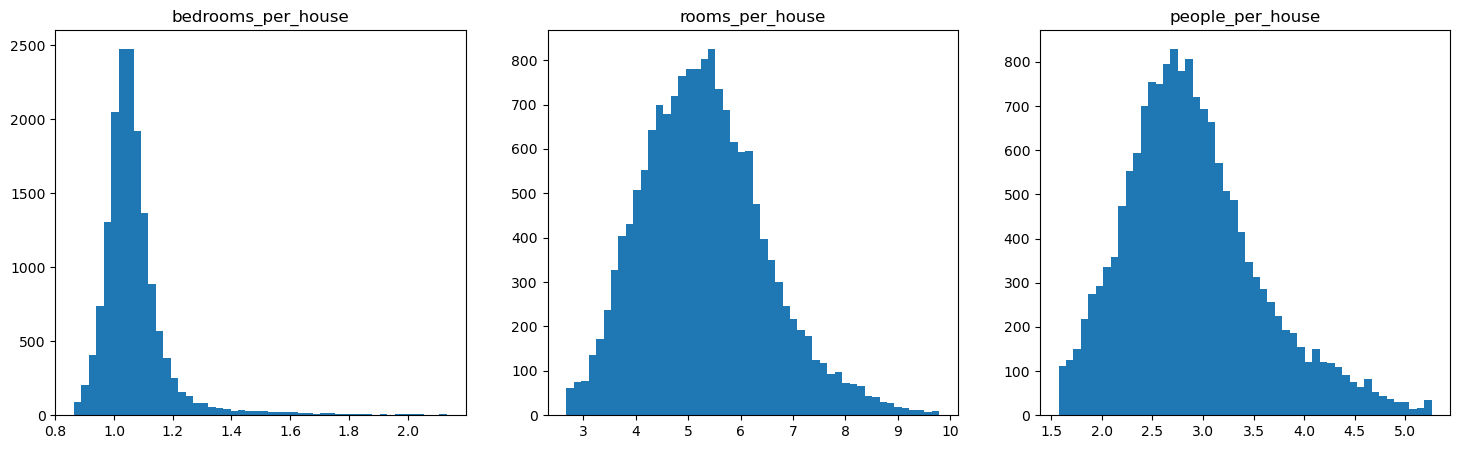

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

extreme_n_to_cut = 200
for i, _ in enumerate(["bedrooms_per_house", "rooms_per_house", "people_per_house"]):
    axes[i].hist(x=sorted(X_train_copy[_])[extreme_n_to_cut:-extreme_n_to_cut], bins=50)
    axes[i].set_title(_)

plt.show()

These already look quite normal when ignoring some outliers, so will apply the standard scaler directly.

Housing median age looks a bit multidoal, so will replace it with two new features using the Gaussian radial basis function (RBF)

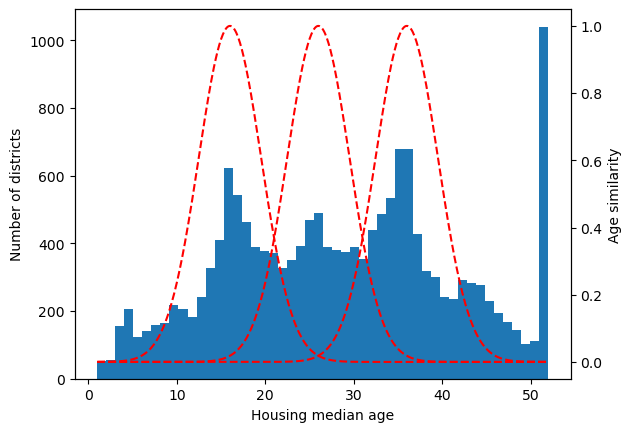

In [13]:
median_age = X_train_copy["housing_median_age"]
ages = np.linspace(median_age.min(), median_age.max(), 500).reshape(-1, 1)
rbf = rbf_kernel(ages, [[16], [26], [36]], gamma=0.04)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.hist(median_age, bins=50)
for _ in range(3):
    ax2.plot(ages, rbf[:, _], c="red", linestyle="--")

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax2.set_ylabel("Age similarity")

plt.show()

In [14]:
def age_similarity_features(age, gamma=0.04):
    return rbf_kernel(age, [[16], [26], [36]], gamma=gamma)


def age_similarity_feature_names(FunctionTransformer, input_features):
    return [f"age_similarity_to_{_}" for _ in [16, 26, 36]]

Applying log to the remaining features to make them more normal.

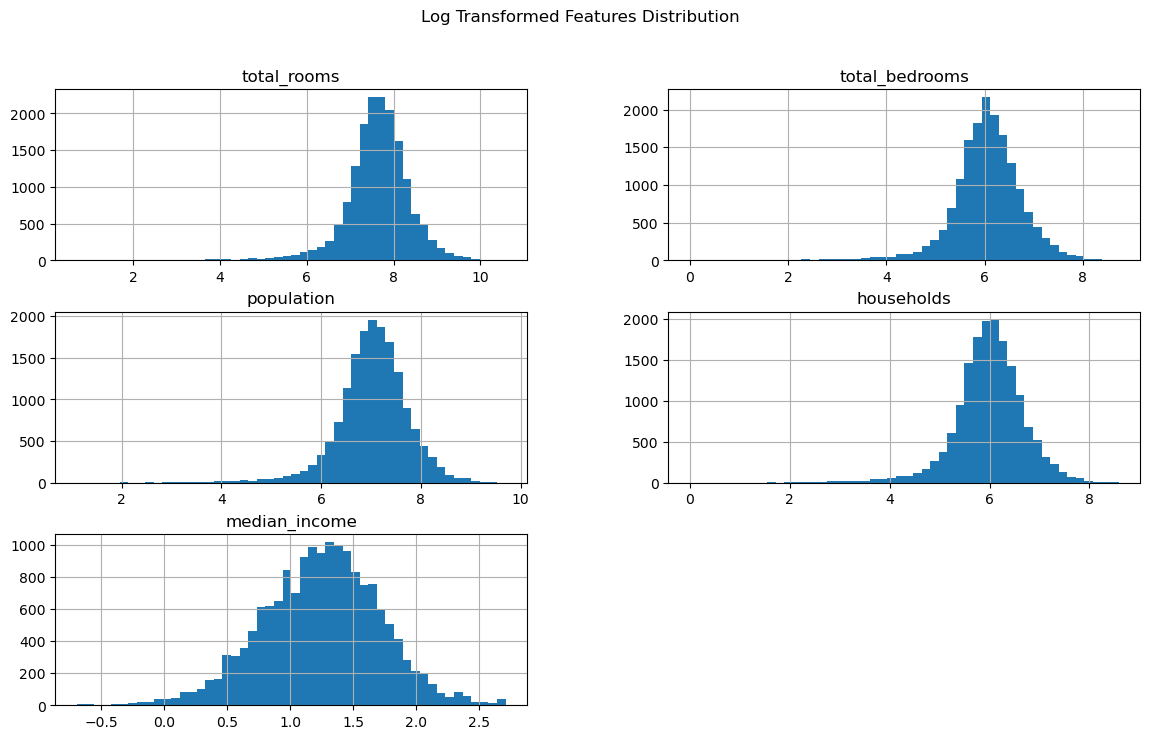

In [15]:
np.log(
    X_train_copy[
        [
            "total_rooms",
            "total_bedrooms",
            "population",
            "households",
            "median_income",
        ]
    ]
).hist(bins=50, figsize=(14, 8))

plt.suptitle("Log Transformed Features Distribution")
plt.show()

Putting this all together into a pipeline

In [16]:
feature_normalization_pipeline = ColumnTransformer(
    [
        (
            "handling_multimodal_median_age",
            FunctionTransformer(
                age_similarity_features,
                feature_names_out=age_similarity_feature_names,
            ),
            ["housing_median_age"],
        ),
        (
            "log_transformation",
            FunctionTransformer(
                np.log,
                feature_names_out="one-to-one",
            ),
            [
                "total_rooms",
                "total_bedrooms",
                "population",
                "households",
                "median_income",
            ],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

feature_normalization_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('handling_multimodal_median_age',
                                 FunctionTransformer(feature_names_out=<function age_similarity_feature_names at 0x144b67f40>,
                                                     func=<function age_similarity_features at 0x144b67eb0>),
                                 ['housing_median_age']),
                                ('log_transformation',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<ufunc 'log'>),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income'])],
                  verbose_feature_names_out=False)

In [17]:
X_train_copy = feature_normalization_pipeline.fit_transform(X_train_copy)
X_train_copy.describe().T[["mean", "std", "min", "max"]].round(2)

,mean,std,min,max
age_similarity_to_16,0.21,0.34,0.00,1.00
age_similarity_to_26,0.22,0.33,0.00,1.00
age_similarity_to_36,0.24,0.36,0.00,1.00
total_rooms,7.63,0.75,0.69,10.58
total_bedrooms,6.05,0.73,0.00,8.73
population,7.03,0.74,1.10,9.70
households,5.98,0.73,0.00,8.59
median_income,1.24,0.47,-0.69,2.71
longitude,-119.57,2.00,-124.35,-114.49
latitude,35.64,2.13,32.55,41.95


In [18]:
scaling_pipeline = ColumnTransformer(
    [
        (
            "standard_scaler",
            StandardScaler(),
            [
                "total_rooms",
                "total_bedrooms",
                "population",
                "households",
                "median_income",
                "bedrooms_per_house",
                "rooms_per_house",
                "people_per_house",
            ],
        )
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

scaling_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('standard_scaler', StandardScaler(),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'bedrooms_per_house', 'rooms_per_house',
                                  'people_per_house'])],
                  verbose_feature_names_out=False)

In [19]:
X_train_copy = scaling_pipeline.fit_transform(X_train_copy)
X_train_copy.describe().T[["mean", "std", "min", "max"]].round(2)

,mean,std,min,max
total_rooms,0.00,1.00,-9.27,3.94
total_bedrooms,0.00,1.00,-8.32,3.68
population,0.00,1.00,-8.04,3.63
households,-0.00,1.00,-8.17,3.56
median_income,0.00,1.00,-4.12,3.11
bedrooms_per_house,0.00,1.00,-1.79,59.95
rooms_per_house,0.00,1.00,-1.77,53.02
people_per_house,0.00,1.00,-0.52,112.06
age_similarity_to_16,0.21,0.34,0.00,1.00
age_similarity_to_26,0.22,0.33,0.00,1.00


#### 3.4 Handling geographic data

In [20]:
class ClusterSimilarity(TransformerMixin, BaseEstimator):
    def __init__(self, n_clusters=10, gamma=1.0):
        self.n_clusters = n_clusters
        self.gamma = gamma

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init="auto")
        self.kmeans_.fit(X)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, input_features=None):
        return [f"cluster_{i}_similarity" for i in range(self.n_clusters)]


geo_pipeline = ColumnTransformer(
    [("cluster_similarity", ClusterSimilarity(), ["longitude", "latitude"])],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

geo_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('cluster_similarity', ClusterSimilarity(),
                                 ['longitude', 'latitude'])],
                  verbose_feature_names_out=False)

In [21]:
X_train_copy = geo_pipeline.fit_transform(X_train_copy)
X_train_copy

,cluster_0_similarity,cluster_1_similarity,cluster_2_similarity,cluster_3_similarity,cluster_4_similarity,cluster_5_similarity,cluster_6_similarity,cluster_7_similarity,cluster_8_similarity,cluster_9_similarity,...,rooms_per_house,people_per_house,age_similarity_to_16,age_similarity_to_26,age_similarity_to_36,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,1.130089e-14,8.069968e-02,2.118723e-08,9.310909e-01,3.457586e-24,1.444764e-04,1.379520e-03,9.877499e-08,1.375692e-01,4.439067e-18,...,-0.866027,-0.330204,3.063191e-23,1.805831e-12,3.571285e-05,0.0,0.0,0.0,1.0,0.0
14973,9.545500e-01,2.473416e-14,1.115893e-01,1.920470e-12,2.716962e-02,3.131410e-04,1.715591e-26,7.182819e-02,2.396026e-09,3.675475e-01,...,0.024550,-0.253616,9.859506e-11,3.936690e-04,5.272924e-01,1.0,0.0,0.0,0.0,0.0
3785,3.904588e-15,4.577835e-01,2.273860e-08,6.039837e-01,1.054667e-24,2.766469e-04,8.143129e-03,1.594477e-08,2.653154e-01,3.035900e-18,...,-0.041193,-0.051041,9.540163e-06,1.408584e-01,6.976763e-01,0.0,1.0,0.0,0.0,0.0
14689,2.766668e-01,6.203618e-20,1.810928e-03,1.331452e-18,4.674573e-01,2.817830e-07,1.899691e-34,1.651325e-04,3.096681e-14,8.802508e-01,...,-0.034858,-0.141475,9.607894e-01,3.916390e-02,5.355348e-07,0.0,1.0,0.0,0.0,0.0
20507,9.442011e-01,1.558986e-16,2.614489e-02,2.014126e-14,1.092615e-01,2.199422e-05,1.772583e-29,1.995417e-02,4.130756e-11,5.442658e-01,...,-0.666554,-0.306148,1.125352e-07,1.831564e-02,1.000000e+00,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,9.476562e-01,1.768288e-15,4.819780e-02,2.847635e-13,4.766683e-02,7.383806e-05,6.064175e-28,5.280662e-02,3.288215e-10,3.601267e-01,...,-0.452111,-0.269780,1.388794e-11,1.234098e-04,3.678794e-01,1.0,0.0,0.0,0.0,0.0
13105,1.390589e-03,2.272751e-05,4.479684e-01,4.133234e-05,2.997399e-08,7.770563e-01,1.559551e-13,4.371814e-02,7.448350e-03,9.983799e-05,...,0.036792,-0.073741,1.408584e-01,6.976763e-01,1.159229e-03,0.0,1.0,0.0,0.0,0.0
19301,3.598291e-02,6.573881e-26,6.280596e-06,2.289335e-23,9.007804e-01,6.455074e-11,6.904038e-42,3.936117e-06,5.271009e-19,1.348301e-01,...,-0.109987,0.158542,6.976763e-01,1.159229e-03,6.461432e-10,0.0,0.0,0.0,0.0,1.0
19121,9.631260e-01,1.285095e-14,9.046371e-02,1.260578e-12,3.110925e-02,2.184157e-04,7.653942e-27,6.982762e-02,1.487825e-09,3.608975e-01,...,-0.360937,-0.210332,2.182958e-08,7.907054e-03,9.607894e-01,1.0,0.0,0.0,0.0,0.0


#### 3.4 Combining it into one pipeline

In [22]:
preprocessing = make_pipeline(
    impute_onehot_pipeline,
    ratio_pipeline,
    feature_normalization_pipeline,
    scaling_pipeline,
    geo_pipeline,
)

preprocessing

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x143806860>),
                                                 ('impute_onehot_categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknow...
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'bedrooms_per_house',
                                                   'rooms_per_house',
                                                   'people_per_house'])],
                                   verbose_feature_names_out=False)),
                ('columntransformer-4',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cluster_similarity',
                                                  ClusterSimilarity(),
                                                  ['longitude', 'latitude'])],
                                   verbose_feature_names_out=False))])

In [23]:
preprocessing.fit_transform(X_train)

,cluster_0_similarity,cluster_1_similarity,cluster_2_similarity,cluster_3_similarity,cluster_4_similarity,cluster_5_similarity,cluster_6_similarity,cluster_7_similarity,cluster_8_similarity,cluster_9_similarity,...,rooms_per_house,people_per_house,age_similarity_to_16,age_similarity_to_26,age_similarity_to_36,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,2.533480e-14,9.706431e-01,4.073793e-24,1.221289e-04,9.031200e-03,2.845260e-17,2.325469e-04,8.842832e-08,1.451407e-01,5.630756e-01,...,-0.866027,-0.330204,3.063191e-23,1.805831e-12,3.571285e-05,0.0,0.0,0.0,1.0,0.0
14973,9.794923e-01,9.201254e-14,2.819858e-02,3.603603e-04,1.307232e-19,5.373426e-01,7.565961e-30,1.187347e-01,1.455142e-11,2.620211e-10,...,0.024550,-0.253616,9.859506e-11,3.936690e-04,5.272924e-01,1.0,0.0,0.0,0.0,0.0
3785,8.783787e-15,7.469200e-01,1.342180e-24,2.346694e-04,1.019144e-01,1.498235e-17,9.258840e-04,2.375140e-08,4.829701e-01,2.853579e-01,...,-0.041193,-0.051041,9.540163e-06,1.408584e-01,6.976763e-01,0.0,1.0,0.0,0.0,0.0
14689,2.382233e-01,3.619997e-20,5.010532e-01,3.488577e-07,5.842777e-26,7.467015e-01,1.580564e-38,4.701799e-04,8.947085e-17,5.136180e-16,...,-0.034858,-0.141475,9.607894e-01,3.916390e-02,5.355348e-07,0.0,1.0,0.0,0.0,0.0
20507,9.129743e-01,7.435367e-16,1.108716e-01,2.589040e-05,3.465957e-22,7.439809e-01,5.338970e-33,3.170191e-02,1.551860e-13,4.308108e-12,...,-0.666554,-0.306148,1.125352e-07,1.831564e-02,1.000000e+00,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,9.496657e-01,1.183506e-14,4.812363e-02,8.564115e-05,5.657363e-21,5.471909e-01,2.545227e-31,7.584122e-02,1.451871e-12,4.906959e-11,...,-0.452111,-0.269780,1.388794e-11,1.234098e-04,3.678794e-01,1.0,0.0,0.0,0.0,0.0
13105,1.932858e-03,8.154673e-06,3.636098e-08,7.986485e-01,1.410858e-08,1.782889e-04,3.852016e-16,1.163275e-01,6.949480e-04,5.038458e-04,...,0.036792,-0.073741,1.408584e-01,6.976763e-01,1.159229e-03,0.0,1.0,0.0,0.0,0.0
19301,2.768174e-02,3.325629e-25,8.673291e-01,8.308174e-11,6.967521e-33,1.262164e-01,3.972813e-46,6.751397e-06,3.943033e-22,2.499517e-20,...,-0.109987,0.158542,6.976763e-01,1.159229e-03,6.461432e-10,0.0,0.0,0.0,0.0,1.0
19121,9.831696e-01,5.822735e-14,3.200856e-02,2.517425e-04,5.951268e-20,5.369884e-01,3.387171e-30,1.099833e-01,8.276336e-12,1.824130e-10,...,-0.360937,-0.210332,2.182958e-08,7.907054e-03,9.607894e-01,1.0,0.0,0.0,0.0,0.0


#### 3.5 Processing the target

In [24]:
target_transformer = make_pipeline(
    FunctionTransformer(
        np.log,
        np.exp,
        feature_names_out="one-to-one",
    ),
    StandardScaler(),
)

target_transformer

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<ufunc 'log'>,
                                     inverse_func=<ufunc 'exp'>)),
                ('standardscaler', StandardScaler())])

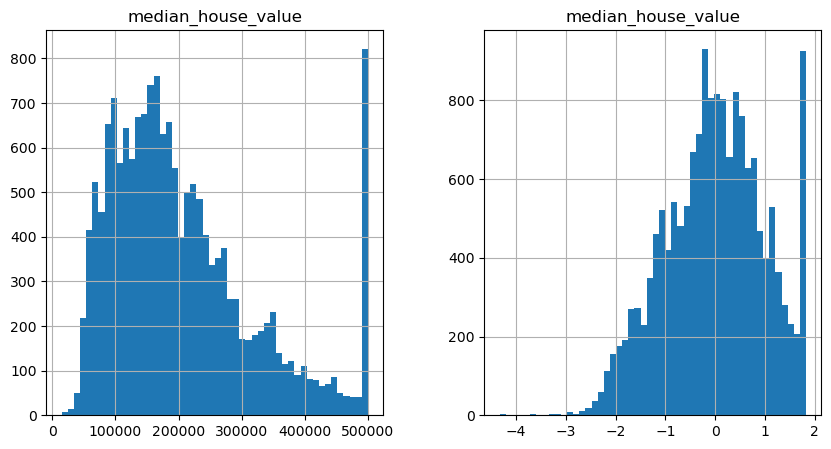

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

y_train.hist(bins=50, ax=axes[0])
target_transformer.fit_transform(y_train).hist(bins=50, ax=axes[1])

plt.show()

### 4. Training the model

In [55]:
model = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler()),
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mean_squared_error(y_test, predictions, squared=False)

75941.34157290806

In [47]:
model = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(SVR(), transformer=target_transformer),
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mean_squared_error(y_test, predictions, squared=False)

55125.12578640475

In [36]:
model = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(DecisionTreeRegressor(), transformer=target_transformer),
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mean_squared_error(y_test, predictions, squared=False)

67520.08011538697